## Define required constants and functions

In [59]:
# Imports
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import numpy.linalg as la

from numpy.polynomial import Polynomial as Poly

# Define constants
T0 = 298 # (K)
k = 200  # (W/mK)
k_f = 26.24e-03  # (W/mK)
tb = 2e-03  # (m)
t = 1.5e-03  # (m)
W = 47e-03  # (m)
L = 60e-03  # (m)
v = 1.48e-05  # (kg/ms) (https://en.wikipedia.org/wiki/Viscosity)
density = 1.177  # (kg/m^3)
Q = 30  # (W)
u = 1.846e-05
c_p = 1.0049e+03
V_f = 2


# Define functions
# Cross sectional area - [Checked] 
def A():
    return t * L


# Fin seperation - [Checked]
def b(N):
    return (W - (N * t)) / (N - 1)


# Perimeter - [Checked]
def P():
    return (2 * L) + (2 * t)


# Channel velocity - [Checked]
def V_ch(V_f, N):
    return V_f * (1 + (t / b(N)))


# Hydraulic diameter (This function is trivial, it used for clarity) - [Checked]
def D_h(N):
    #print(N)
    #print(b(N))
    return 2 * b(N)


# Channel Reynolds number - [Checked]
def c_rn(V_f, N):
    return (D_h(N) * V_ch(V_f, N)) / v


# Modified channel Reynolds number - [Checked]
def m_c_rn(V_f, N):
    return (b(N) * V_ch(V_f, N) / v) * (b(N) / L)


# Prandtl number - [Checked]
def Pr():
    #return 0.707  # This just return a hard coded value for now
    return (c_p * u) / k_f

# Nessult number - [Checked]
def n_n(V_f, N, H):
    first_term = (m_c_rn(V_f, N) * Pr() / 2) ** -3
    second_term = (0.664 * np.sqrt(m_c_rn(V_f, N)) * (Pr() ** (1/3)) * np.sqrt(1 + (3.65 / np.sqrt(m_c_rn(V_f, N))))) ** -3
    return (first_term + second_term) ** (-1/3)


# Heat transfer coefficient - [Checked]
def h(N, H, V_f):
    return (n_n(V_f, N, H) * k_f) / b(N)


# Fin parameter - [Checked]
def m(N, H, V_f):
    return np.sqrt(h(N, H, V_f) * P() / (k * A()))


# Resistance of each fin - [Checked]
def R_fin(N, H, V_f):
    return 1 / (np.sqrt(h(N, H, V_f) * P() * k * A()) * np.tanh(m(N, H, V_f) * H))


# Resistance of the heat sink - [Checked]
def R_sink(N, H, V_f):
    first_term = 1 / ((N / R_fin(N, H, V_f)) + (h(N, H, V_f) * (N - 1) * b(N) * L))
    second_term = tb / (k * L * W)
    return first_term + second_term

# Sigma - [Checked]
def sigma(N):
    return 1 - ((N * t) / W)


# Compression loss coefficient - [Checked]
def K_c(N):
    return 0.42 * (1 - (sigma(N) ** 2))


# Expansion loss coefficient  - [Checked]
def K_e(N):
    return (1 - (sigma(N) ** 2)) ** 2


# Dimensionless fin length - [Checked]
def L_star(V_f, N):
    return L / (D_h(N) * c_rn(V_f, N))


# Friction factor - [Checked]
def ff(N, H, V_f):
    first_term = 32.527 * (b(N) / H)
    second_term = 46.721 * ((b(N) / H) ** 2)
    third_term = 40.829 * ((b(N) / H) ** 3)
    fourth_term = 22.954 * ((b(N) / H) ** 4)
    fifth_term = 6.089 * ((b(N) / H) ** 5)
    numerator = 24 - first_term + second_term - third_term + fourth_term - fifth_term
    return numerator / c_rn(V_f, N)


# Apparent friction factor - [Checked]
def f_app(N, H, V_f):
    return np.sqrt(((3.44 / np.sqrt(L_star(V_f, N))) ** 2) + (((ff(N, H, V_f) * c_rn(V_f, N))) ** 2)) / c_rn(V_f, N)


# Total drag force - [Checked]
def F_d(N, H, V_f):
    dynamic_pressure = (1 / 2) * density * (V_ch(V_f, N) ** 2)
    return dynamic_pressure * (f_app(N, H, V_f) * N * ((2 * H * L) + (b(N) * L))) + (K_c(N) * H * W) + (K_e(N) * H * W)


# Pressure drop - [Checked]
def pd(N, H, V_f):
    return F_d(N, H, V_f) / (H * W)


# Entropy generation rate - [Checked]
def S_gen_rate(N, H, V_f):
    first_term = ((Q ** 2) * R_sink(N, H, V_f)) / (T0 ** 2)
    second_term = F_d(N, H, V_f) * (V_f / T0)
    return first_term + second_term

# Fan curve data
air_flow = np.array([  # (m^3/minute)
    0.000986,
    0.010927,
    0.019692, 
    0.026641,
    0.033804, 
    0.04086, 
    0.045887, 
    0.050378, 
    0.056473, 
    0.059575, 
    0.063212, 
    0.068988, 
    0.074659, 
    0.079047, 
    0.087290, 
    0.092428, 
    0.101310, 
    0.112542, 
    0.121313, 
    0.129334, 
    0.139600, 
    0.148688, 
    0.158951, 
    0.167931, 
    0.177445, 
    0.188669, 
    0.197220, 
    0.205665, 
    0.215929, 
    0.224376, 
    0.232290, 
    0.241380, 
    0.249081, 
    0.255499, 
    0.262240, 
    0.266948, 
    0.271015, 
    0.273263,
])

static_pressure = np.array([  # mm-H20
    29.7972,
    29.3063,
    28.8032,
    28.3493,
    27.8342,
    27.2824,
    26.7185,
    26.2771,
    25.6886,
    25.2107,
    24.7450,
    23.9483,
    22.9680,
    22.1348,
    20.1990,
    19.0473,
    17.3931,
    15.8366,
    14.6478,
    13.7897,
    12.7598,
    11.9506,
    11.2147,
    10.6014,
    10.0738,
    9.4970,
    9.0552,
    8.4664,
    7.6693,
    6.9336,
    6.1000,
    5.1316,
    4.1510,
    3.2319,
    2.1045,
    1.2345,
    0.4380,
    0.0000,
])

## Plot the entropy generation rate as a function of N

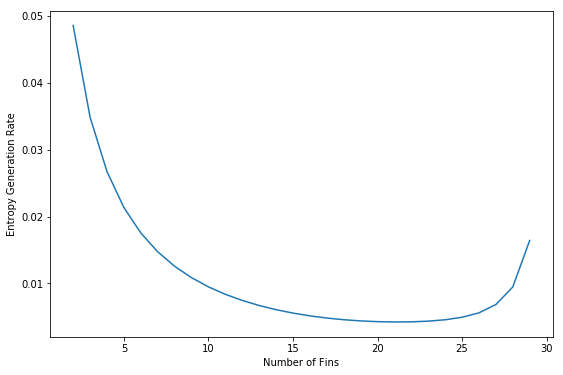

In [60]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (9, 6)

H = 25e-3
V_f = 2

values = []
for N in range(2, 30):
    values.append(S_gen_rate(N, H, V_f))

N = range(2, 30)
plt.ylabel("Entropy Generation Rate")
plt.xlabel("Number of Fins")
plt.plot(N, values)

## Plot the entropy generation rate as a function of H

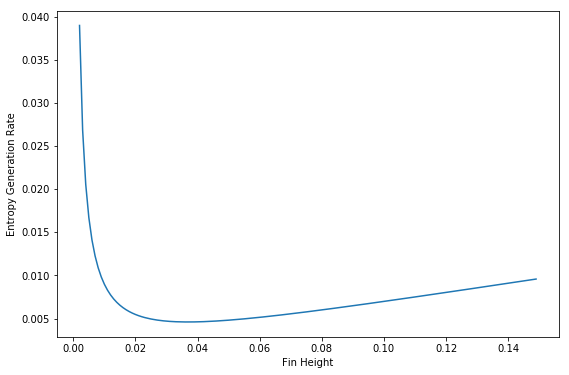

In [61]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (9, 6)

N = 25
V_f = 2

values = []
for H in range(2, 150):
    H *= 1e-3
    values.append(S_gen_rate(N, H, V_f))

H = range(2, 150)
H = [val * 1e-3 for val in H]
plt.ylabel("Entropy Generation Rate")
plt.xlabel("Fin Height")
plt.plot(H, values)

## Plot the entropy generation rate as a function of $V_f$

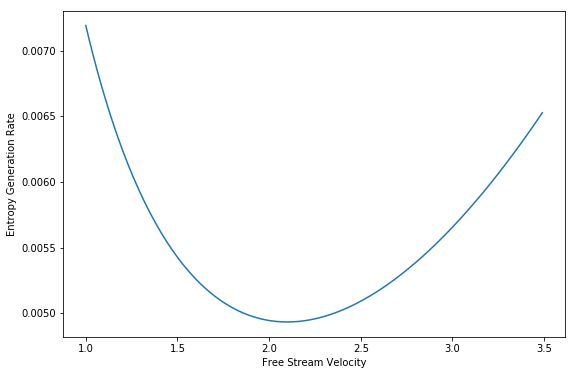

In [62]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (9, 6)

H = 25e-3
N = 25

values = []
for V_f in np.arange(1, 3.5, 0.01):
    values.append(S_gen_rate(N, H, V_f))

V_f = np.arange(1, 3.5, 0.01)
plt.ylabel("Entropy Generation Rate")
plt.xlabel("Free Stream Velocity")
plt.plot(V_f, values)

## Solve for $N$, $H$, and $V_f$ 

In [14]:
# Define the function to be optimised
def f(x, y, z):
    #return ((x + 5) ** 2) + ((y + 2) ** 2) - 10
    return ((Q ** 2) * R_sink(x, y, z) / (T0 ** 2) + (F_d(x, y, z) * z / T0))

# Define the first and second partial derivatives wrt N (x), H (y), and V_f (z)
delta = 1e-05


def dfdx(x, y, z):
    return (f(x + delta, y, z) - f(x, y, z)) / delta


def dfdy(x, y, z):
    return (f(x, y + delta, z) - f(x, y, z)) / delta


def dfdz(x, y, z):
    return (f(x, y, z + delta) - f(x, y, z)) / delta


def ddfdxx(x, y, z):
    return (f(x + delta, y, z) - (2 * f(x, y, z)) + f(x - delta, y, z)) / (delta ** 2)


def ddfdyy(x, y, z):
    return (f(x, y + delta, z) - (2 * f(x, y, z)) + f(x, y - delta, z)) / (delta ** 2)


def ddfdzz(x, y, z):
    return (f(x, y, z + delta) - (2 * f(x, y, z)) + f(x, y, z - delta)) / (delta ** 2)


def ddfdxy(x, y, z):
    return (f(x + delta, y + delta, z) - f(x + delta, y - delta, z) - f(x - delta, y + delta, z) + f(x - delta, y - delta, z)) / (4 * delta ** 2)


def ddfdyz(x, y, z):
    return (f(x, y + delta, z+ delta) - f(x, y + delta, z - delta) - f(x, y - delta, z + delta) + f(x, y - delta, z - delta)) / (4 * delta ** 2)


def ddfdxz(x, y, z):
    return (f(x + delta, y, z+ delta) - f(x + delta, y, z - delta) - f(x - delta, y, z + delta) + f(x - delta, y, z - delta)) / (4 * delta ** 2)


class solve_N_H_Vf:
    def newtons_method():
        x_vector = np.matrix('25 ; 25.0e-03 ; 2')  # Initial feature vector
        e = 1e-05  # Tolerance value
        i = 0  # Count variable
        newton_step = np.matrix('1')  # Set the Newton step to a dummy "Truthy" value to start the loop
        while (newton_step > e).any():
            # Get the individual values from the feature vector
            x = x_vector[0,0]
            y = x_vector[1,0]
            z = x_vector[2,0]

            # Define the Hessian matrix
            H_matrix_param = [ddfdxx(x, y, z)], [ddfdxy(x, y, z)], [ddfdxz(x, y, z)], [ddfdxy(x, y, z)], [ddfdyy(x, y, z)], [ddfdyz(x, y, z)], [ddfdxz(x, y, z)], [ddfdyz(x, y, z)], [ddfdzz(x, y, z)]
            H_matrix = np.matrix(H_matrix_param).reshape(3, 3)

            # Define the gradient vector of the function
            gradient_vector_param = [dfdx(x, y, z)], [dfdy(x, y, z)], [dfdz(x, y, z)]
            gradient_vector = np.matrix(gradient_vector_param)

            # Carry out Newton's method
            newton_step = np.dot(la.inv(H_matrix), gradient_vector)

            # Update the feature vector
            x_vector -= newton_step

            # Increment the count variable
            i += 1
            # Print the results of the current iteration
            print("Iteration: {} | N: {}, H: {}mm, V_f: {}m/s, \u03B8: {} degrees".format(i, format(x_vector[0,0], '.2f'), format(y * 1000, '.2f'), format(x_vector[2,0], '.2f'), format((Q * R_sink(x_vector[0,0], x_vector[1,0], V_f)), '.2f')))

        if np.absolute(dfdx(x_vector[0,0], x_vector[1,0], x_vector[2,0])) < e:
            # If the method completes successfully then print thr results
            print("\nFound minimum with {} fins, each {}mm tall, with free stream velocity {}m/s in {} iterations.".format(int(round(x)), int(round(1000 * x_vector[1,0])), format(z, '.2f'), i))
        else:
            # If the method does not reduce the gradient of the fucntion sufficiently then indicate it has failed
            print("Failed after {} iterations.".format(i))
            
    def gradient_descent(momentum=False, beta=0.9, learning_rate=0.5, print_results=False):
        x_vector = np.matrix('25 ; 25.0e-03 ; 2')  # Initial feature vector
        e = 1e-04  # Tolerance value
        i = 0  # Count variable
        derivative_vector = np.matrix('1')
        momentum_vector = np.zeros(x_vector.shape)
        while (derivative_vector > e).any():
            x = x_vector[0,0]
            y = x_vector[1,0]
            z = x_vector[2,0]
                    
            #print(derivative_vector)
        
            # Define the gradient vecotrs matrix
            derivative_vector_param = [dfdx(x, y, z), dfdy(x, y, z), dfdz(x, y, z)]
            derivative_vector = np.matrix(derivative_vector_param).T
                        
            if momentum:   
                # Apply momentum
                momentum_vector = (beta * momentum_vector) + ((1 - beta) * derivative_vector) #/ (1 - np.power(beta, i + 1))
                
                # Update the feature vector using momentum
                x_vector -= learning_rate * momentum_vector
            else:
                # Update the feature vector without using momentum
                x_vector -= learning_rate * derivative_vector
            
            # Increment the count variable
            i += 1
            # Print the results of the current iteration
            if i % 10000 == 0 and print_results:
                print("Iteration: {} | N: {}, H: {}mm, V_f: {}m/s, \u03B8: {} degrees".format(i, format(x_vector[0,0], '.2f'), format(y * 1000, '.2f'), format(x_vector[2,0], '.2f'), format((Q * R_sink(x_vector[0,0], x_vector[1,0], V_f)), '.2f')))
        
        if print_results:
            if (derivative_vector > e).any() < e:
                # If the method completes successfully then print thr results
                print("\nFound minimum with {} fins, each {}mm tall, with free stream velocity {}m/s in {} iterations.".format(int(round(x)), int(round(1000 * x_vector[1,0])), format(z, '.2f'), i))
            else:
                # If the method does not reduce the gradient of the fucntion sufficiently then indicate it has failed
                print("Failed after {} iterations.".format(i))

In [15]:
tic = time.time()
# solve_N_H_Vf.gradient_descent(momentum=False, beta=0.9, learning_rate=2, print_results=True)
solve_N_H_Vf.newtons_method()
toc = time.time()

print("Newton's Method took {} seconds to converge.".format(format(toc - tic, '.4f')))

Iteration: 1 | N: 22.11, H: 25.00mm, V_f: 2.17m/s, θ: 8.26 degrees
Iteration: 2 | N: 19.54, H: 35.68mm, V_f: 1.97m/s, θ: 6.84 degrees
Iteration: 3 | N: 18.29, H: 53.24mm, V_f: 1.77m/s, θ: 6.22 degrees
Iteration: 4 | N: 18.02, H: 73.31mm, V_f: 1.63m/s, θ: 5.88 degrees
Iteration: 5 | N: 17.96, H: 91.44mm, V_f: 1.54m/s, θ: 5.73 degrees
Iteration: 6 | N: 17.95, H: 104.27mm, V_f: 1.52m/s, θ: 5.68 degrees
Iteration: 7 | N: 17.95, H: 109.24mm, V_f: 1.51m/s, θ: 5.68 degrees
Iteration: 8 | N: 17.95, H: 109.85mm, V_f: 1.51m/s, θ: 5.68 degrees
Iteration: 9 | N: 17.95, H: 109.86mm, V_f: 1.51m/s, θ: 5.68 degrees

Found minimum with 18 fins, each 110mm tall, with free stream velocity 1.51m/s in 9 iterations.
Newton's Method took 0.0360 seconds to converge.


## Plot the polyfit fan curve

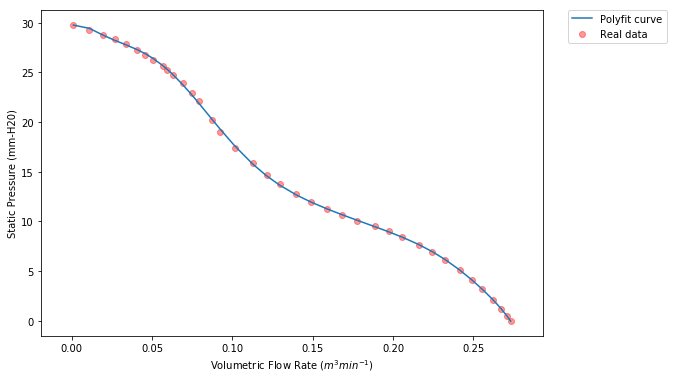

In [58]:
# Use numpy to fit a curve to the fan data 
# coefs = poly.polyfit(air_flow, static_pressure, 5)
# ffit = poly.polyval(air_flow, coefs)
p = Poly.fit(air_flow, static_pressure, deg=10)


# Given a value for the pressure drop get the positive 
# real root of the function when shifted down by the value
def V_f_fan_curve(N, H, V_f):
    pd_ = pd(N, H, V_f)
    conversion_factor = H * W * 60
    if pd_ > 29:
        return 0.000986 / conversion_factor
    if pd_ < 0:
        return 0.273263 / conversion_factor
    roots = (p - pd(N, H, V_f)).roots()
    for root in roots:
        if not root.imag and root.real >= 0:
            return root.real / conversion_factor

V_f = 2
H = 30e-03
y_values = []
x_values = []

for N in range(2, 30):
    x_values.append(V_f_fan_curve(N, H, V_f))
    y_values.append(pd(N, H, V_f))

# print(x_values)
# print(y_values)

# plt.plot(x_values, y_values)
plt.ylabel("Static Pressure (mm-H20)")
plt.xlabel("Volumetric Flow Rate ($m^3min^{-1}$)")
plt.scatter(air_flow, static_pressure, color='r', alpha=0.4, label='Real data')
plt.plot(air_flow, p(air_flow), label='Polyfit curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Solve for $N$ with fan curve

In [56]:
# Define the equation to be minimised
def f(x):
    return ((Q ** 2) * R_sink(x, H, V_f) / (T0 ** 2)) + (F_d(x, H, V_f) * V_f / T0)

# Define the first and second order derivatives of f(x)
delta = 1e-05  # Define the "inifintesimal"

# def dfdx(x):
#     return (f(x + delta) - f(x)) / delta


def dfdx(x):
    return (f(x + delta) - f(x - delta)) / (2 * delta)


def ddfdxx(x):
    return (f(x + delta) - (2 * f(x)) + f(x - delta)) / (delta ** 2)


def solve_N_fan_curve(type_, learning_rate=None):
    # Define constants and initial values
    x = 15  # Number of fins
    H = 50e-03
    V_f = 2
    e = 1e-05
    i = 0
    values = []
    iterations = []
    costs = []
    # Run Newton's method until the derivative of the function is within 1e-08 of zero
    while np.absolute(dfdx(x)) > e:
        # Increment the counter
        i += 1
        print("Iteration: {} | N: {}, V_f: {}, \u03B8: {}, S: {}".format(i, format(x, '.2f'), V_f, format((Q * R_sink(x, H, V_f)), '.2f'), format(f(x), '.5f')))
        V_f = V_f_fan_curve(x, H, V_f)
        if type_ == "newtons_method":
            x -= dfdx(x) / ddfdxx(x)
        elif type_ == "gradient_descent":
            x -= learning_rate * dfdx(x)
        
        
        if i % 100 == 0:
            values.append(x)
            iterations.append(i)
            costs.append(S_gen_rate(x, H, V_f))
        
#         if i % 1000 == 0 and type_== "gradient_descent": # Output each iterations results
#             print("Iteration: {} | N: {}, V_f: {}, \u03B8: {}, S: {}".format(i, format(x, '.2f'), V_f, format((Q * R_sink(x, H, V_f)), '.2f'), format(f(x), '.5f')))
# #             print(np.absolute(dfdx(x)))
#         elif type_ == "newtons_method":
#             print("Iteration: {} | N: {}, V_f: {}, \u03B8: {}, S: {}".format(i, format(x, '.2f'), V_f, format((Q * R_sink(x, H, V_f)), '.2f'), format(f(x), '.5f')))

    # Output the final result
    print("\nFound minimum with {} fins, in {} iterations.".format(int(round(x)), i))
    
    return values, iterations, costs

In [57]:
tic = time.time()
N_values, iterations, costs = solve_N_fan_curve("gradient_descent", 12000)
toc = time.time()

print("Gradient descent took {} seconds to converge.\n".format(format(toc - tic, '.4f')))

tic = time.time()
_,_,_ = solve_N_fan_curve("newtons_method")
toc = time.time()

print("Newton's Method took {} seconds to converge.".format(format(toc - tic, '.4f')))

Iteration: 1 | N: 15.00, V_f: 2, θ: 9.55, S: 0.00482
Iteration: 2 | N: 19.65, V_f: 0.9686842135473261, θ: 11.87, S: 0.00380
Iteration: 3 | N: 20.45, V_f: 0.7720450133466498, θ: 14.23, S: 0.00377

Found minimum with 21 fins, in 3 iterations.
Gradient descent took 0.0030 seconds to converge.

Iteration: 1 | N: 15.00, V_f: 2, θ: 9.55, S: 0.00482
Iteration: 2 | N: 19.56, V_f: 0.9686842135473261, θ: 11.89, S: 0.00381

Found minimum with 21 fins, in 2 iterations.
Newton's Method took 0.0020 seconds to converge.


## Solve for $N$ and $H$ with fan curve

In [19]:
# Define the function to be optimised
def f(x, y):
    #return ((x + 5) ** 2) + ((y + 2) ** 2) - 10
    return (Q ** 2) * R_sink(x, y, V_f) / (T0 ** 2) + (F_d(x, y, V_f) * V_f / T0)

# Define the first and second partial derivatives wrt N (x) and H (y)
delta = 1e-05


def dfdx(x, y):
    return (f(x + delta, y) - f(x, y)) / delta


def dfdy(x, y):
    return (f(x, y + delta) - f(x, y)) / delta


def ddfdxx(x, y):
    return (f(x + delta, y) - (2 * f(x, y)) + f(x - delta, y)) / (delta ** 2)


def ddfdyy(x, y):
    return (f(x, y + delta) - (2 * f(x, y)) + f(x, y - delta)) / (delta ** 2)


def ddfdxy(x, y):
    return (f(x + delta, y + delta) - f(x + delta, y - delta) - f(x - delta, y + delta) + f(x - delta, y - delta)) / (4 * delta ** 2)


# Define the initial feature vector
x_vector = np.matrix('10 ; 10.0e-03')
V_f = 2
e = 1e-6
i = 0
newton_step = np.matrix('1')
while (newton_step > e).any():
    # Get the individual values from the feature vector
    x = x_vector[0,0]
    y = x_vector[1,0]
    
    
    # Define the Hessian matrix
    H_matrix_param = [ddfdxx(x, y)], [ddfdxy(x, y)], [ddfdxy(x, y)], [ddfdyy(x, y)]
    H_matrix = np.matrix(H_matrix_param).reshape(2, 2)
    
    # Define the gradient vector of the function
    gradient_vector_param = [dfdx(x, y)], [dfdy(x, y)]
    gradient_vector = np.matrix(gradient_vector_param)
    
    # Carry out Newton's method
    newton_step = np.dot(la.inv(H_matrix), gradient_vector)
    print(newton_step)
    x_vector -= newton_step
        
    V_f = V_f_fan_curve(x_vector[0,0], x_vector[1,0], V_f)

    print(x, y, V_f)
    
    
    # Increment the count variable
    i += 1
    # Print the results of the current iteration
    print("Iteration: {} | N: {}, H: {}mm, V_f: {}m/s, \u03B8: {} degrees".format(i, format(x_vector[0,0], '.2f'), format(y * 1000, '.2f'), format(V_f, '.2f'), format((Q * R_sink(x_vector[0,0], x_vector[1,0], V_f)), '.2f')))
    
if (newton_step > e).any():
    # If the method completes successfully then print thr results
    print("\nFound minimum with {} fins, each {}mm tall, with free stream velocity {}m/s in {} iterations.".format(int(round(x)), int(round(1000 * x_vector[1,0])), format(z, '.2f'), i))
else:
    # If the method does not reduce the gradient of the fucntion sufficiently then indicate it has failed
    print("\nFailed after {} iterations.".format(i))

[[ -4.17997523e+00]
 [ -3.24530705e-03]]
10.0 0.01 4.33925972991
Iteration: 1 | N: 14.18, H: 10.00mm, V_f: 4.34m/s, θ: 21.77 degrees

Failed after 1 iterations.
